In [1]:
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
import math
import random
from tqdm.notebook import trange
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import torch

# Generating data:
_______

This code generates samples where macro cluster assignment is inline with microcluster assignemnt (something that happens almost never in traffic captures).

In [3]:
def generate_samples(N, M, m, evenly, DIM):

    if evenly:
        # This code forces the macro-centroids to be evenly
        # distributed in the feaure space.
        division_range = math.ceil(math.sqrt(M)) + 1
        proto_centroids = np.array(
            [i/division_range for i in range(division_range)])
        proto_centroids = list(product(proto_centroids, repeat=DIM))
        proto_centroids = proto_centroids[division_range:]
        macrocluster_centers = random.sample(proto_centroids, M)
        macrocluster_centers += np.random.uniform(
            0,
            1,
            size=(M, DIM)) * 0.005
    else:
        # Generate macrocluster centers:
        macrocluster_centers = np.random.uniform(
            0,
            1,
            size=(M, DIM))

    micro_centroids = []
    # Generate microcluster centers:
    for macro_centroid in macrocluster_centers:
        micro_centroids.append(np.random.uniform(
                                macro_centroid - 0.1,
                                macro_centroid + 0.1,
                                size=(m, DIM)))
    micro_centroids = np.concatenate(micro_centroids)

    # Generate samples from T bivariate Gaussian distributions
    samples = np.zeros((N, DIM))
    macro_labels = []
    micro_labels = []
    for i in trange(N):
        # Select a random microcluster for the current sample
        micro_label = np.random.randint(0, M*m)
        macro_labels.append(micro_label // m)
        micro_labels.append(micro_label)

        micro_centroid = micro_centroids[micro_label]

        # Generate sample from a bivariate Gaussian distribution around
        # the chosen centroid

        # 1. Covariance matrix (we assume 0 covariance between the variables,
        # i.e., we want to generate ellipsoids):
        # Specify the diagonal elements as a 1D array
        diagonal_elements = np.random.rand(DIM) * 0.00001 # Adjust the size as needed
        # Create a diagonal matrix
        covariance = np.diag(diagonal_elements)
        samples[i, :] = np.random.multivariate_normal(micro_centroid, covariance)

    return samples, macro_labels, micro_labels

In [55]:
# Parameters
M = 16             # Number of macro classes
m = 4              # Number of micro classes per macro class
N = 500 * M * m   # Number of samples
DIM = 2
evenly = True

super_samples = []
for i in range(5):

    # Generate samples
    samples, macro_labels, micro_labels = generate_samples(
        N, M, m, evenly, DIM)

    super_samples.append(samples)

samples = np.concatenate(
    super_samples, 1)

  0%|          | 0/32000 [00:00<?, ?it/s]

  0%|          | 0/32000 [00:00<?, ?it/s]

  0%|          | 0/32000 [00:00<?, ?it/s]

  0%|          | 0/32000 [00:00<?, ?it/s]

  0%|          | 0/32000 [00:00<?, ?it/s]

# Generating Fuzzy synthetic data:
________

This code generates a more fuzzy geometry of data with respect to the epistemics: macro-clusters are not necessarily aligned with its micro-clusters. It resembles better the initial conditions of a classification manifold, and turns to be more robust for our processor to learn hierarchical clustering.

In [3]:
def generate_samples(N, M, m, evenly, DIM, fuzzy_macro):

    if evenly:
        # This code forces the macro-centroids to be evenly
        # distributed in the feaure space.
        division_range = math.ceil(M**(1/DIM)) + 1
        proto_centroids = np.array(
            [i/division_range for i in range(division_range)])
        proto_centroids = list(product(proto_centroids, repeat=DIM))
        proto_centroids = proto_centroids[division_range:]
        macrocluster_centers = random.sample(proto_centroids, M)
        macrocluster_centers += np.random.uniform(
            0,
            1,
            size=(M, DIM)) * 0.005
    else:
        # Generate macrocluster centers:
        macrocluster_centers = np.random.uniform(
            0,
            1,
            size=(M, DIM))

    micro_centroids = []
    # Generate microcluster centers:
    for macro_centroid in macrocluster_centers:
        micro_centroids.append(np.random.uniform(
                                macro_centroid - 0.1,
                                macro_centroid + 0.1,
                                size=(m, DIM)))
    micro_centroids = np.concatenate(micro_centroids)

    # Generate samples from T bivariate Gaussian distributions
    samples = np.zeros((N, DIM))
    macro_labels = []
    micro_labels = []
    for i in trange(N):
        # Select a random microcluster for the current sample
        micro_label = np.random.randint(0, M*m)
        if fuzzy_macro:
            """
            Macro-semanticity doesn't has anything to do
            with micro-semanticity, (realistic setting)
            """
            macro_labels.append(micro_label % M)
        else:
            """
            This code generates samples where macro cluster assignment is
            inline with microcluster assignemnt (something that happens
            almost never in traffic captures).
            """
            macro_labels.append(micro_label // m)
        micro_labels.append(micro_label)

        micro_centroid = micro_centroids[micro_label]

        # Generate sample from a bivariate Gaussian distribution around
        # the chosen centroid

        # 1. Covariance matrix (we assume 0 covariance between the variables,
        # i.e., we want to generate ellipsoids):
        # Specify the diagonal elements as a 1D array
        diagonal_elements = np.random.rand(DIM) * 0.00001  # Adjust the size as needed
        # Create a diagonal matrix
        covariance = np.diag(diagonal_elements)
        samples[i, :] = np.random.multivariate_normal(micro_centroid, covariance)

    return samples, macro_labels, micro_labels

In [4]:
# Parameters
M = 12             # Number of macro classes
m = 5              # Number of micro classes per macro class
N = 500 * M * m   # Number of samples
DIM = 15
evenly = True
fuzzy_macro = False

super_samples = []
for i in range(1):

    # Generate samples
    samples, macro_labels, micro_labels = generate_samples(
        N, M, m, evenly, DIM, fuzzy_macro)

    super_samples.append(samples)

samples = np.concatenate(
    super_samples, 1)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [5]:
# Create a Pandas DataFrame from your NumPy array
data = pd.DataFrame(data=samples)

# Create a pandas DataFrame
data['Macro Label'] = macro_labels
data['Micro Label'] = micro_labels

In [6]:
# Perform PCA
pca = PCA(n_components=2)  # You can change the number of components as needed
principal_components = pca.fit_transform(
    data.drop(columns=['Macro Label', 'Micro Label']).values)

# Create a DataFrame for the principal components (for plotting)
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Macro Label'] = macro_labels
pca_df['Micro Label'] = micro_labels

In [15]:
import itertools

# List of colors
colors = [
    'red', 'blue', 'green', 'purple', 'orange', 'pink', 'cyan',  'brown', 'yellow',
    'olive', 'lime', 'teal', 'maroon', 'navy', 'fuchsia', 'aqua', 'silver', 'sienna', 'gold',
    'indigo', 'violet', 'turquoise', 'tomato', 'orchid', 'slategray', 'peru', 'magenta', 'limegreen',
    'royalblue', 'coral', 'darkorange', 'darkviolet', 'darkslateblue', 'dodgerblue', 'firebrick',
    'lightseagreen', 'mediumorchid', 'orangered', 'powderblue', 'seagreen', 'springgreen', 'tan', 'wheat',
    'burlywood', 'chartreuse', 'crimson', 'darkgoldenrod', 'darkolivegreen', 'darkseagreen', 'indianred',
    'lavender', 'lightcoral', 'lightpink', 'lightsalmon', 'limegreen', 'mediumseagreen', 'mediumpurple',
    'midnightblue', 'palegreen', 'rosybrown', 'saddlebrown', 'salmon', 'slateblue', 'steelblue',
]

# Create an iterator that cycles through the colors
color_iterator = itertools.cycle(colors)

/tmp/ipykernel_262047/2528522748.py:28: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


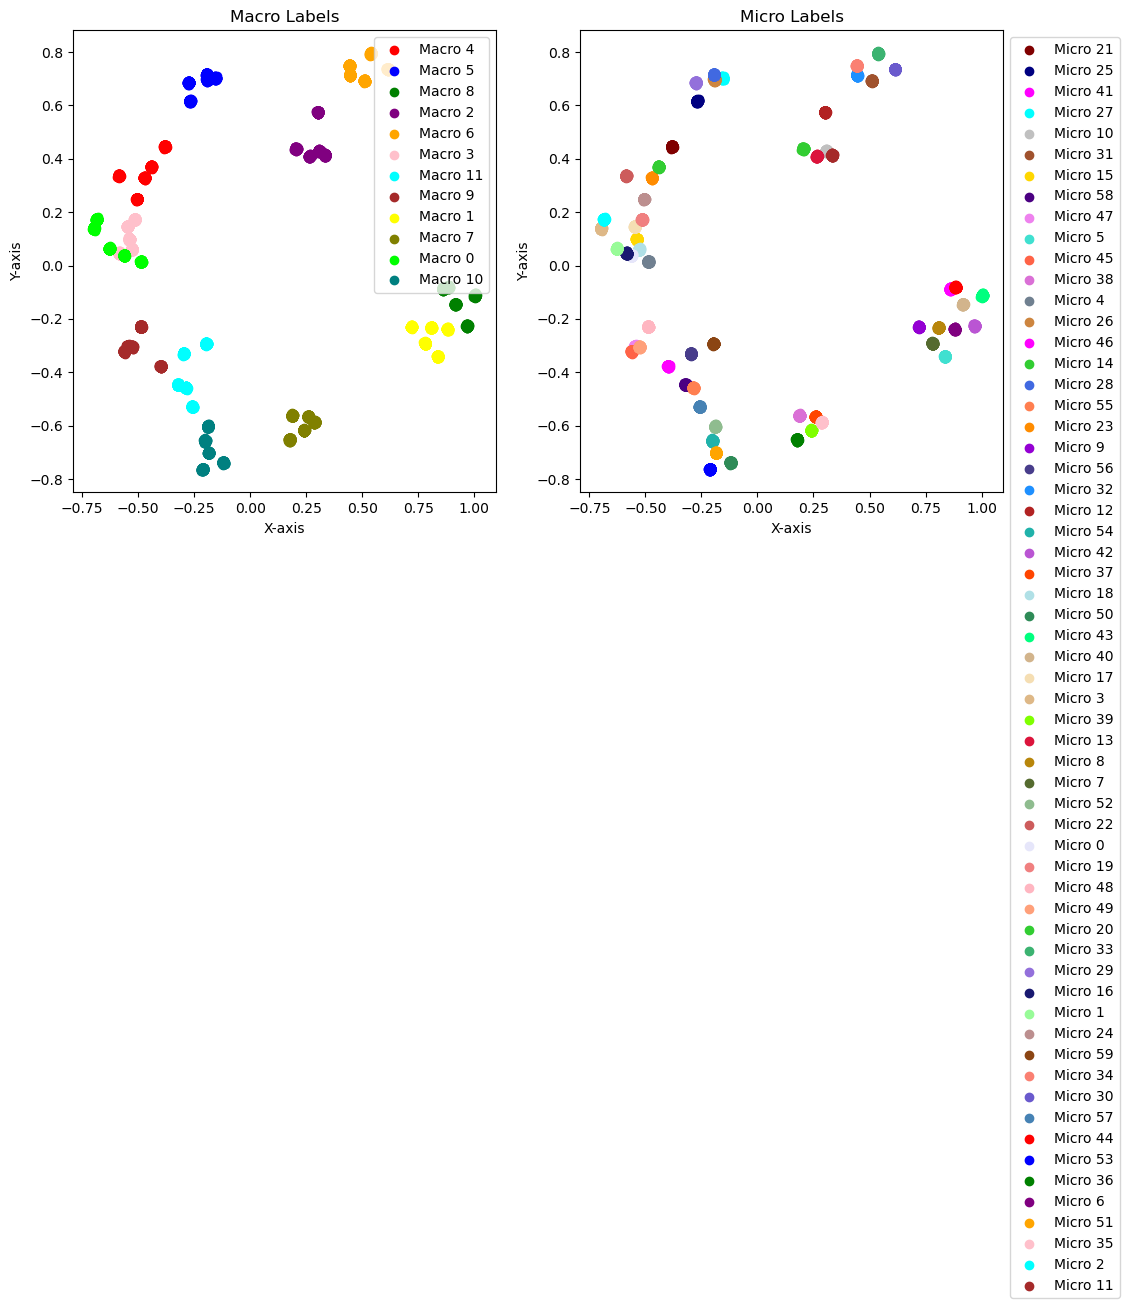

In [16]:
# Separate data into macro and micro labels
macro_data = pca_df[pca_df['Macro Label'].notnull()]
micro_data = pca_df[pca_df['Micro Label'].notnull()]

# Create separate plots for macro labels and micro labels
plt.figure(figsize=(12, 6))

# Plot for macro labels
plt.subplot(1, 2, 1)
for macro_label in macro_data['Macro Label'].unique():
    macro_label_data = macro_data[macro_data['Macro Label'] == macro_label]
    plt.scatter(macro_label_data['PC1'], macro_label_data['PC2'], label=f'Macro {macro_label}', c=next(color_iterator))
plt.title('Macro Labels')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()

# Plot for micro labels
plt.subplot(1, 2, 2)
for micro_label in micro_data['Micro Label'].unique():
    micro_label_data = micro_data[micro_data['Micro Label'] == micro_label]
    plt.scatter(micro_label_data['PC1'], micro_label_data['PC2'], label=f'Micro {micro_label}', c=next(color_iterator))
plt.title('Micro Labels')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

plt.tight_layout()
plt.show()

In [8]:
# Save the DataFrame to a CSV file
data.to_csv(
    f'/home/jovyan/shared/jesus/datasets/synthetic/M_{M}_m_{m}_DIM_{DIM}_N_{N}.csv',
    index=False)

In [10]:
data = pd.read_csv(f'/home/jovyan/shared/jesus/datasets/synthetic/M_{M}_m_{m}_DIM_{DIM}_N_{N}.csv')
macro_labels = list(data['Macro Label'])
micro_labels = list(data['Micro Label'])

# Manual Labelling:
__________
To ensure result reproducibility, we manually choose which clusters to label as Type A and Type B zdas, so that every processor training has the same exact dataset ;)

In [ ]:
def plot_masked_dataset(
    data):

    micro_type_A_ZdAs = data[data['Type_A_ZdA'] == True]['Micro Label'].unique()
    micro_type_B_ZdAs = data[data['Type_B_ZdA'] == True]['Micro Label'].unique()

    # Separate data into macro and micro labels
    macro_data = data[data['Macro Label'].notnull()]
    micro_data = data[data['Micro Label'].notnull()]

    # Create separate plots for macro labels and micro labels
    plt.figure(figsize=(12, 12)

    # Plot for micro labels
    plt.subplot(1, 1, 1)
    for micro_label in micro_data['Micro Label'].unique():
        micro_label_data = micro_data[micro_data['Micro Label'] == micro_label]
        if np.isin(micro_label, micro_type_B_ZdAs):
            plt.scatter(micro_label_data['0'],
                        micro_label_data['1'],
                        label=f'Type B ZdA {micro_label}',
                        c='gray',
                        alpha=0.3)
        elif np.isin(micro_label, micro_type_A_ZdAs):
            plt.scatter(micro_label_data['0'],
                        micro_label_data['1'],
                        label=f'Type A ZdA {micro_label}',
                        c='black',
                        alpha=0.3)
        else:
            plt.scatter(micro_label_data['0'],
                        micro_label_data['1'],
                        label=f'Micro {micro_label}',
                        c=next(color_iterator),
                        alpha=0.5)

    plt.title('Synthetic Data')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

    plt.tight_layout()
    plt.show()


Notice that we have generated very few samples per cluster:

In [12]:
data.groupby(['Macro Label','Micro Label']).count()['0']

Macro Label  Micro Label
0            0              486
             1              505
             2              519
             3              521
             4              495
1            5              506
             6              507
             7              546
             8              538
             9              484
2            10             457
             11             504
             12             508
             13             535
             14             467
3            15             509
             16             500
             17             471
             18             493
             19             471
4            20             494
             21             528
             22             506
             23             489
             24             455
5            25             493
             26             493
             27             461
             28             501
             29             521
6            30

We choose type A and type B Zdas:

In [17]:
micro_zdas = [25,26,27,28,29,35,36,37,38,39,10,11,12,13,14,30,31,32,33,34,0,1,2,5,6,7,15,16,17,20,21,22,40,41,45,46,50,51,55,56]
micro_type_A_ZdAs = [25,26,27,28,29,35,36,37,38,39,10,11,12,13,14,30,31,32,33,34]
micro_type_B_ZdAs = [0,1,2,5,6,7,15,16,17,20,21,22,40,41,45,46,50,51,55,56]
train_type_A_macro_classes = [5,7]
test_type_A_macro_classes = [2,6]
train_type_B_micro_classes = [0,1,2,5,6,7,15,16,17,20,21]
test_type_B_micro_classes = [22,40,41,45,46,50,51,55,56]

In [18]:
data['ZdA'] = np.where(
        data['Micro Label'].isin(micro_zdas),
        True,
        False)

data['Type_A_ZdA'] = np.where(
    data['Micro Label'].isin(micro_type_A_ZdAs),
    True,
    False)

data['Type_B_ZdA'] = np.where(
    data['Micro Label'].isin(micro_type_B_ZdAs),
    True,
    False)

assert np.all(
    set(micro_type_A_ZdAs) == set(data[data.Type_A_ZdA]['Micro Label'].unique()))

assert np.all(
    set(micro_type_B_ZdAs) == set(data[data.Type_B_ZdA]['Micro Label'].unique()))


In [19]:
macro_classes = data['Macro Label'].unique()
micro_classes = data['Micro Label'].unique()
macro_classes.sort()
micro_classes.sort()

type_A_ZdAs = data[data.Type_A_ZdA == True]
micro_type_A_ZdAs = type_A_ZdAs['Micro Label'].unique()
macro_type_A_zdas = type_A_ZdAs['Macro Label'].unique()

assert all(item in macro_type_A_zdas for item in train_type_A_macro_classes)
assert all(item in macro_type_A_zdas for item in test_type_A_macro_classes)

type_B_ZdAs = data[data.Type_B_ZdA == True]
micro_type_B_ZdAs = type_B_ZdAs['Micro Label'].unique()

assert all(item in micro_type_B_ZdAs for item in train_type_B_micro_classes)
assert all(item in micro_type_B_ZdAs for item in test_type_B_micro_classes)


print(f'Micro classes {micro_classes}\n')
print(f'Micro type A ZdAs {micro_type_A_ZdAs}\n')
print(f'Micro type B ZdAs {micro_type_B_ZdAs}\n\n')

known_classes = np.array(
    list(
        set(micro_classes) -
        set(micro_type_B_ZdAs) -
        set(micro_type_A_ZdAs)))
print(f'Known micro classes {known_classes}\n')


# Type A ZdAs:
print(f'test_type_A_macro_classes {test_type_A_macro_classes}\n')
print(f'train_type_A_macro_classes {train_type_A_macro_classes}\n')

# Type B ZdAs:
print(f'test_type_B_micro_classes {test_type_B_micro_classes}\n')
print(f'train_type_B_micro_classes {train_type_B_micro_classes}\n')

# Data splitting:
test_mask = np.zeros(len(data))

# some unknown attacks are exclusively in the test dataset:
# type B:
test_mask = np.logical_or(
    test_mask,
    data['Micro Label'].isin(test_type_B_micro_classes))
# type A:
test_mask = np.logical_or(
    test_mask,
    data['Macro Label'].isin(test_type_A_macro_classes))

# we take a percentage of known attacks also in the test dataset:
train_percentage = 0.8
known_test_mask = np.zeros(len(data[~data.ZdA]))
known_test_mask = torch.rand(len(known_test_mask)) > train_percentage
known_test_mask = known_test_mask.numpy()
test_mask[~data.ZdA] = known_test_mask
# effective split:
test_data = data[test_mask].copy()
train_data = data[~test_mask].copy()

Micro classes [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]

Micro type A ZdAs [25 27 10 31 38 26 14 28 32 12 37 39 13 33 29 34 30 36 35 11]

Micro type B ZdAs [21 41 15  5 45 46 55 56 50 40 17  7 22  0 20 16  1  6 51  2]


Known micro classes [ 3  4  8  9 18 19 23 24 42 43 44 47 48 49 52 53 54 57 58 59]

test_type_A_macro_classes [2, 6]

train_type_A_macro_classes [5, 7]

test_type_B_micro_classes [22, 40, 41, 45, 46, 50, 51, 55, 56]

train_type_B_micro_classes [0, 1, 2, 5, 6, 7, 15, 16, 17, 20, 21]



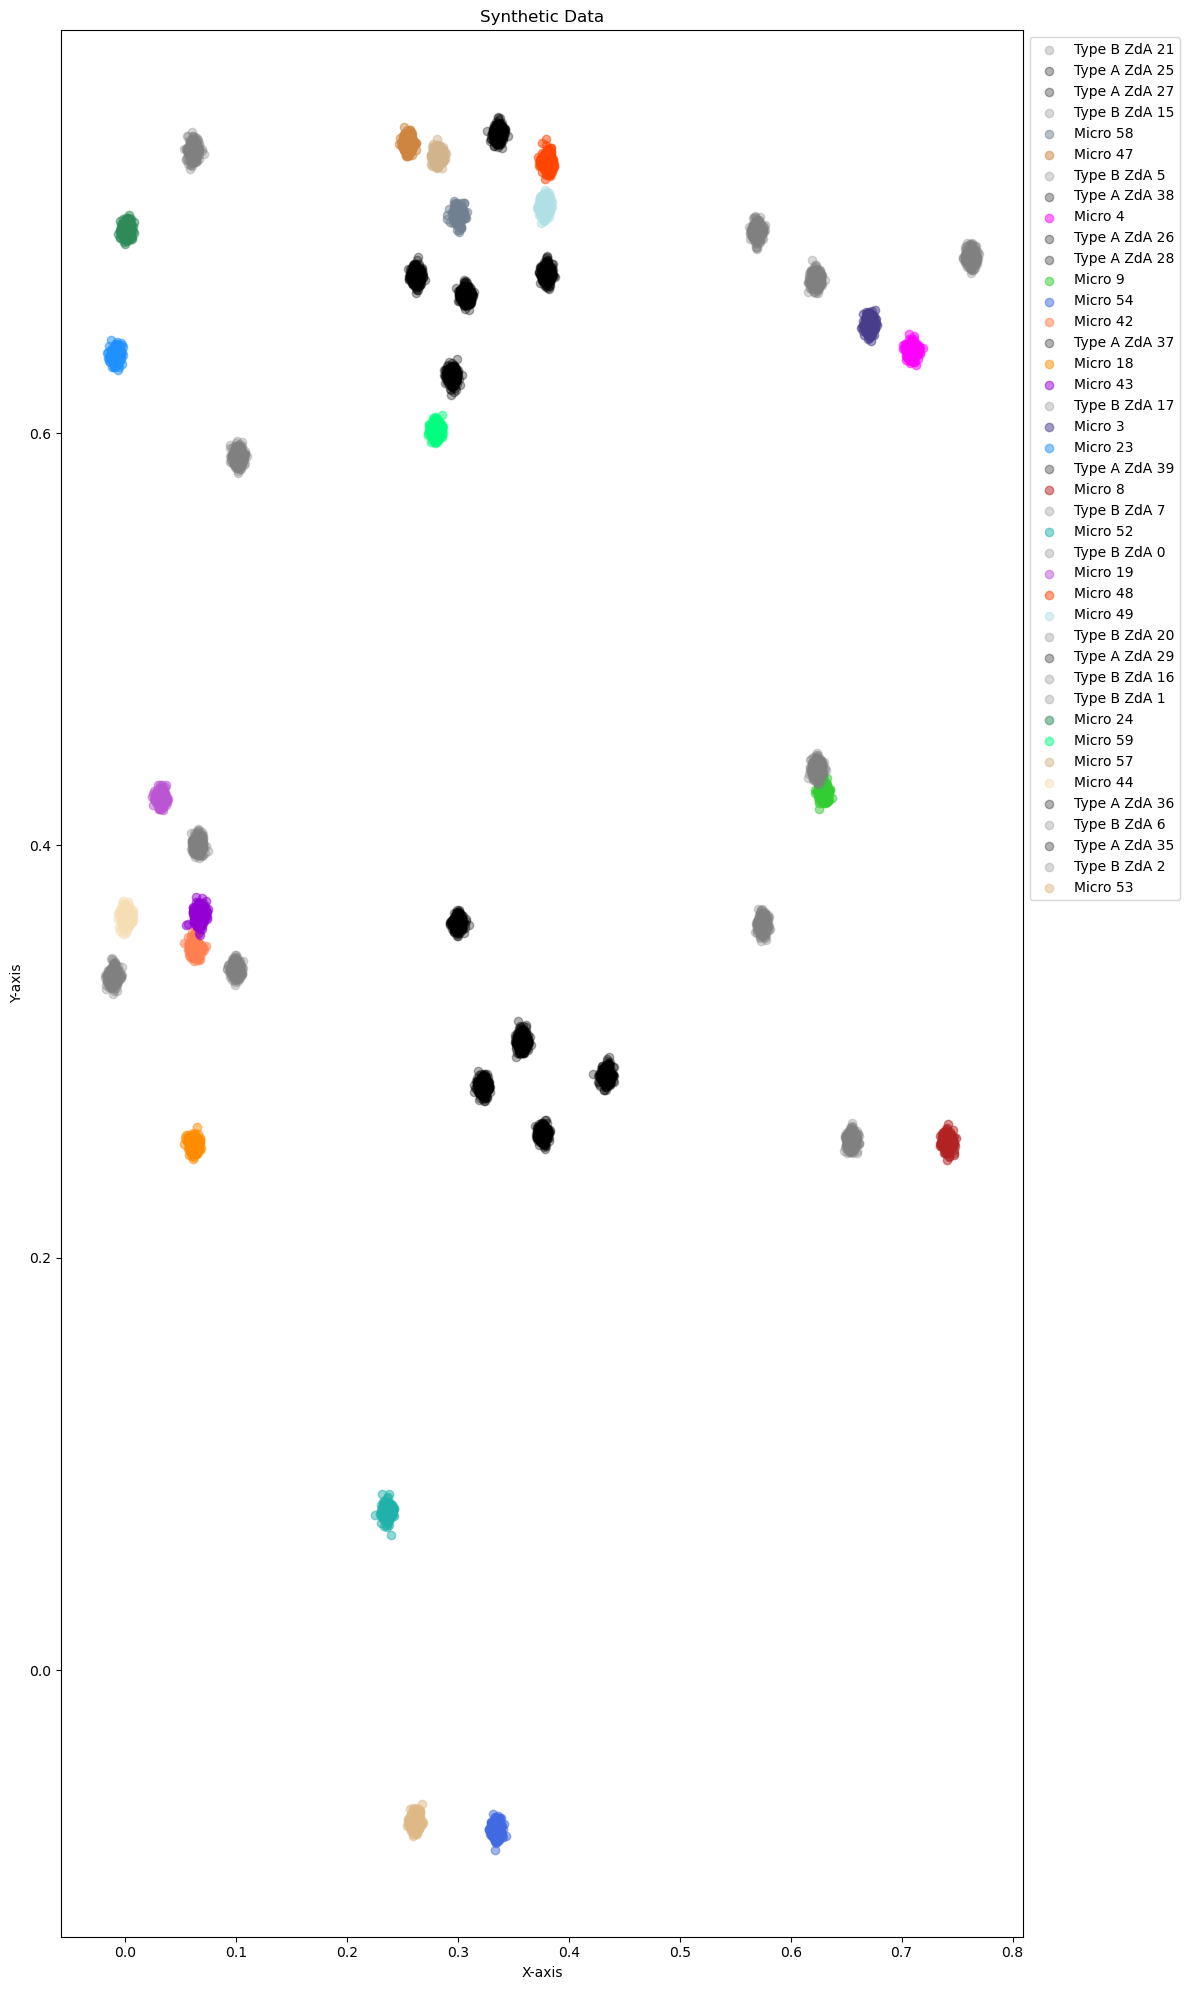

In [34]:
plot_masked_dataset(train_data)

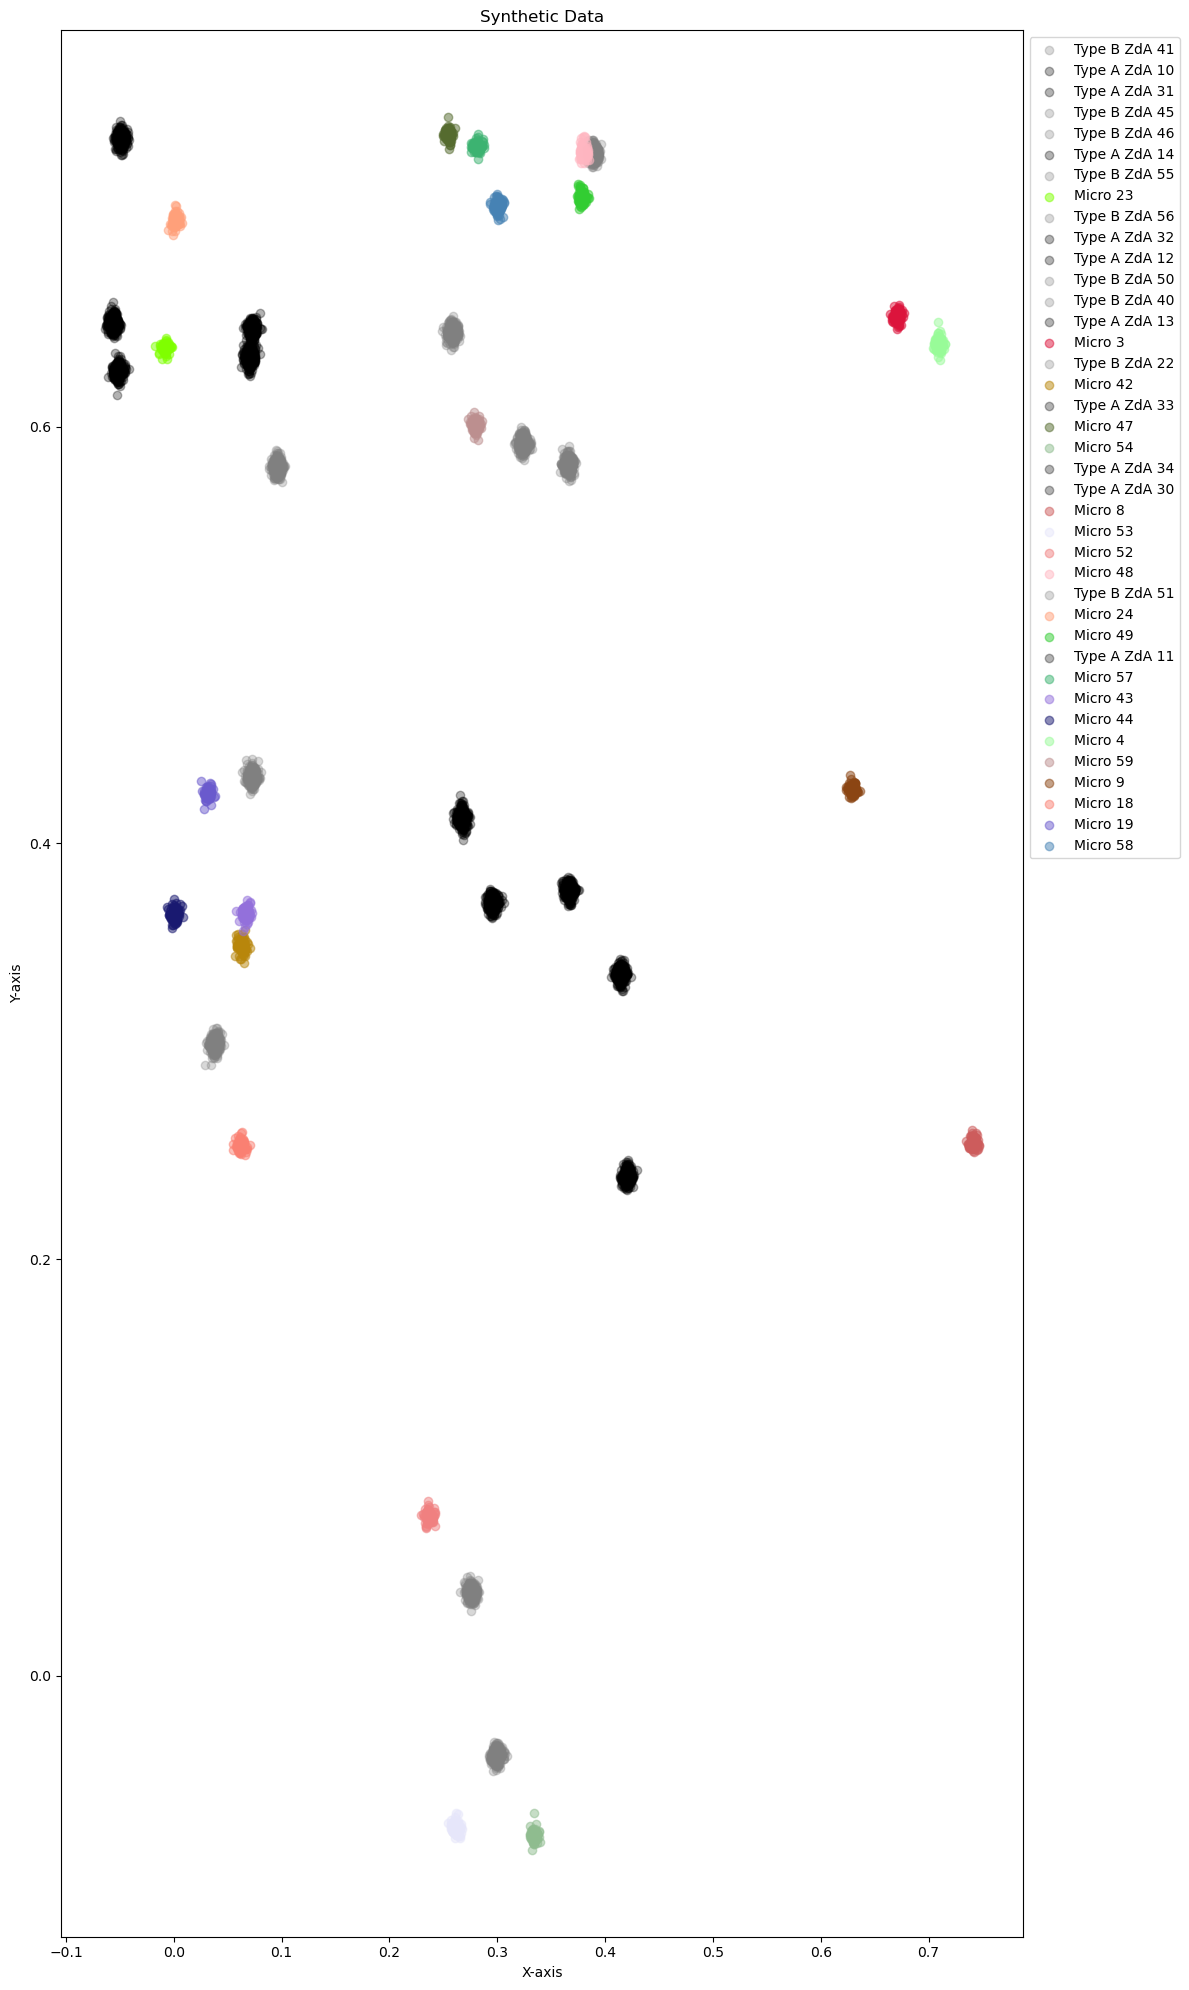

In [35]:
plot_masked_dataset(test_data)

In [ ]:
data_dir = '/home/jovyan/shared/jesus/datasets/synthetic/' # change this as needed...

In [22]:
train_data.to_csv(
    f'{data_dir}train_M_{M}_m_{m}_DIM_{DIM}_N_{N}.csv.csv',
    index=False)

In [23]:
test_data.to_csv(
    f'{data_dir}test_M_{M}_m_{m}_DIM_{DIM}_N_{N}.csv.csv',
    index=False)